In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from collections import defaultdict

In [32]:
dfp = pd.read_csv('plants.csv')
dfc = pd.read_csv('clients.csv')
dfm = pd.read_csv('materials.csv')
dft = pd.read_parquet('transactions.parquet')

In [33]:
# dft_pl is some part of transaction dataframe (it is logical to take data from one plant as dft_pl)
# returns a dictionary which maps:
# material -> np.array of its buy count by every day
# (len of array is number of dates in dft_pl)
def mat_dynamics(dft_pl):
    from collections import defaultdict
    dates = np.sort(dft_pl.chq_date.unique())
    mat_dyn = defaultdict(lambda: np.zeros(len(dates), dtype='int'))
    for i, dat in enumerate(dates):
        dft_pl_dat = dft_pl[dft_pl.chq_date == dat]
        mat_buys = dft_pl_dat.groupby('material').chq_id.count()
        for mat, cnt in mat_buys.items():
            mat_dyn[mat][i] = cnt # / total_buys
    return mat_dyn

# returning boolean if we can distinguish between absence and non-buying for this material
# if dyn is like [1 0 0 1 0 2 1 0 1 ...], we probably can't distinguish it
def can_tell_absence(dyn, buys_thres=2, len_thres=10):
    dyn1 = dyn[dyn != 0]
    return len(dyn1) >= len_thres and dyn1.mean() >= buys_thres

In [34]:
# this code can be executed but its result can be load by np.load in the end of this cell
# it generates mat_dyn_sel: it is a dict : [(plant, material)] -> np.array of 366 int32 (for 366 days in the year)
# for all (plant, material) pairs for which we can distinguish if product is "absent" and "wasn't purchased"

# mat_dyn_sel = defaultdict(lambda: np.zeros(len(dates), dtype='int'))
# for pl in dft.plant.unique():
#     dft_pl = dft[dft.plant == pl]
#     mat_dyn = mat_dynamics(dft_pl)
#     cta_cnt = 0
#     for mat, dyn in mat_dyn.items():
#         if can_tell_absence(dyn):
#             cta_cnt += 1
#             mat_dyn_sel[(pl, mat)] = dyn 
#     print(pl, len(dft_pl), ':', cta_cnt, '/', len(mat_dyn), '=', cta_cnt / len(mat_dyn))
# np.save('mat_dyn_sel2.npy', dict(mat_dyn_sel))

# just load the result of commented code above instead of executing it (~1hour)
mat_dyn_sel = np.load('mat_dyn_sel.npy')[()]

# plots for the presentation are actually made using mat_dyn_sel generated by can_tell_absence(buys_thres=1.5),
# but its serialisation occupies >25 MB

In [35]:
dates = np.sort(dft.chq_date.unique())

In [36]:
client = '473cd850c5c5ded9dc295526e0261dc0'
dft_cl0 = dft[dft.client_id == client]
print(len(dft_cl0.plant.unique()))

1


In [37]:
plant = dft_cl0.plant.unique()[0]
dft_cl = dft_cl0[dft_cl0.plant == plant]
chq_dates = np.sort(dft_cl.chq_date.unique())
dft_cl.shape

(313, 9)

In [38]:
mats = dft_cl.material.unique()
len(mats)

237

In [39]:
mats_cta = {} # cta ~ can tell absence (see function of same name)
for mat in mats:
    dyn = mat_dyn_sel.get((plant, mat))
    if dyn is None:
        continue
#     print(mat, dyn)
    mats_cta[mat] = dyn

In [40]:
def get_h4(mat):
    return dfm[dfm.material == mat].hier_level_4.iloc[0]
# btw, dfm[dfm.material == 'f48b2e8c06c6871b247cce89743fd5d5'] is empty lol, but dft has that material

In [41]:
mats_cta_h4 = set(get_h4(mat) for mat in mats_cta.keys())
mats_vis = [mat for mat in mats if get_h4(mat) in mats_cta_h4]

h4_idx = {}
i = 3
for mat in mats_vis:
    mat_h4 = get_h4(mat)
    if mat_h4 not in h4_idx.keys():
        h4_idx[mat_h4] = i
        i += 1

mats_vis = np.array(mats_vis)[np.argsort([h4_idx[get_h4(mat)] for mat in mats_vis])]
print(len(mats_cta), '/', len(mats_vis))

23 / 36


In [42]:
matrix = np.zeros((len(mats_vis), len(chq_dates)), dtype='int32')
for (i, mat) in enumerate(mats_vis):
    for (j, dat) in enumerate(chq_dates):
        date_idx = int((dat - dates[0]) / (dates[1] - dates[0]))
        dyn = mats_cta.get(mat)
        matrix[i,j] = -1
        if dyn is not None:
            dyn_el = dyn[date_idx]
            if dyn_el == 0:
                matrix[i,j] = 0
                continue
        found = len(dft_cl[(dft_cl.chq_date == dat) & (dft_cl.material == mat)])
        if found >= 1:
            matrix[i,j] = h4_idx[get_h4(mat)]
        else:
            matrix[i,j] = 2 if dyn is not None else 1
            # 2 ~ white, 1 ~ light gray
last_date_idx = date_idx
rng = range(last_date_idx+1,366,1)
matrix_rest = np.zeros((len(mats_vis), len(rng)), dtype='int32')
for (i, mat) in enumerate(mats_vis):
    for (j, date_idx) in enumerate(rng):
#         date_idx = int((dat - dates[0]) / (dates[1] - dates[0]))
        dat = dates[date_idx]
        dyn = mats_cta.get(mat)
        matrix_rest[i,j] = -1
        if dyn is not None:
            dyn_el = dyn[date_idx]
            if dyn_el == 0:
                matrix_rest[i,j] = 0
                continue
        found = len(dft_cl[(dft_cl.chq_date == dat) & (dft_cl.material == mat)])
        if found == 1:
            matrix_rest[i,j] = h4_idx[get_h4(mat)]
        else:
            matrix_rest[i,j] = 2 if dyn is not None else 1
# matrix
chq_dates_rest = np.array([dates[date_idx] for date_idx in rng])
extra_days = 7
chq_dates_full = np.hstack((chq_dates,chq_dates_rest[:extra_days]))
print(chq_dates_full.shape)
matrix_full = np.hstack((matrix, matrix_rest[:, :extra_days]))
print(matrix.shape, matrix_rest.shape, matrix_full.shape)

(32,)
(36, 25) (36, 143) (36, 32)


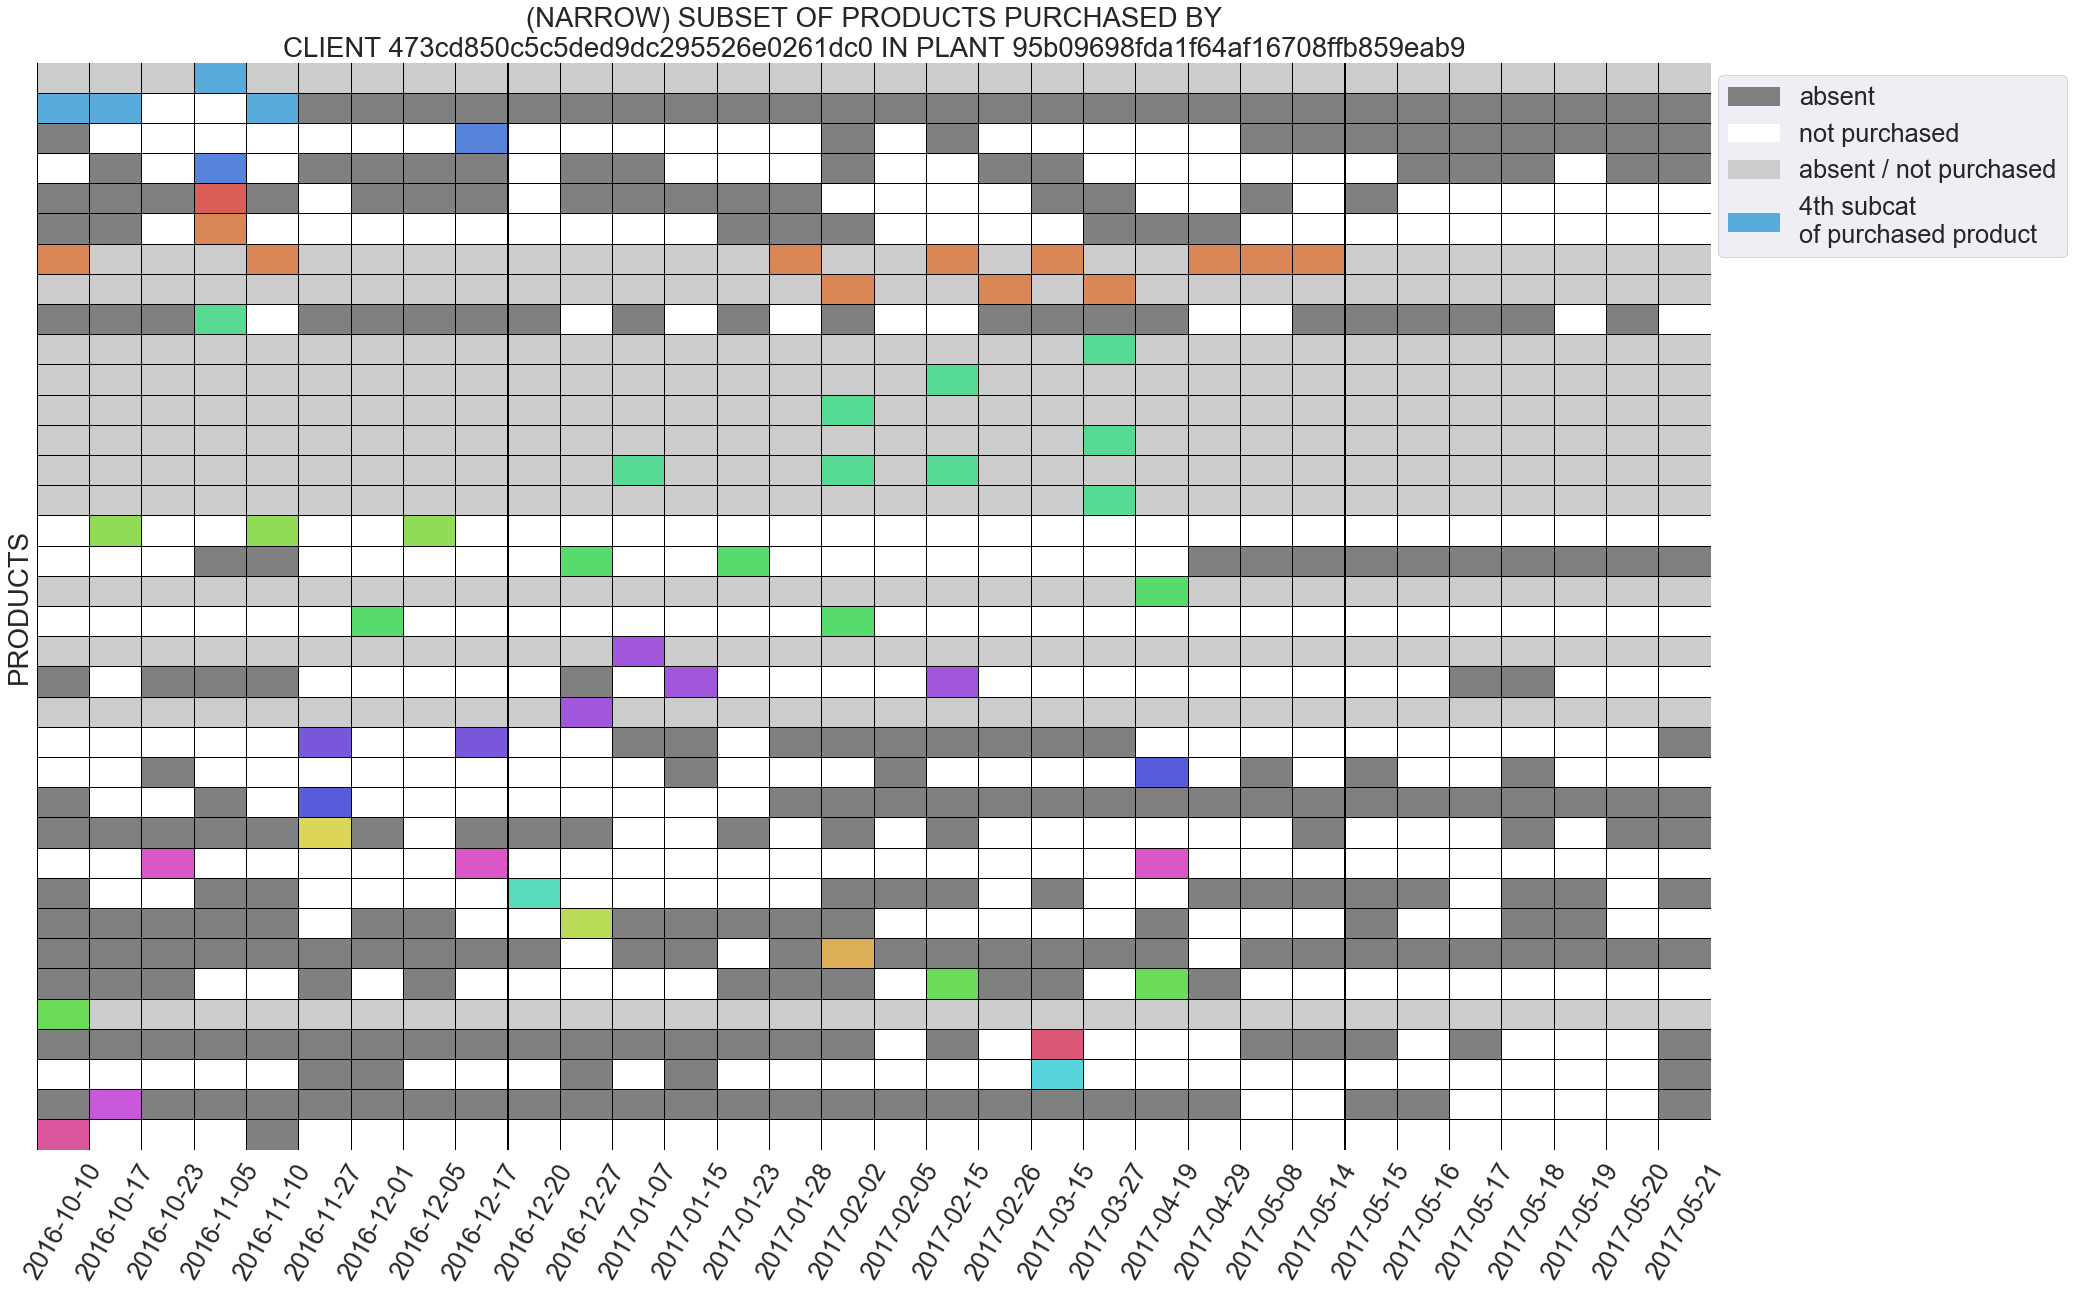

In [43]:
# at this chart, I took products for which we can distinguish its absence from
# "not having been bought" (in the selected plant), and added to them all products
# that have the same subcategories of 4th hierarchy level
# (all products are selected from products bought by selected client at selected plant)

np.random.seed(13)
cmap = np.random.permutation(sns.color_palette("hls", len(h4_idx)))
cmap = [tuple([0.5]*3), tuple([0.8]*3), tuple([1]*3)] + [tuple(color) for color in cmap]

sns.set(font_scale=2.3, rc={'figure.figsize': (30, 20)})
ax = sns.heatmap(matrix_full, cmap=cmap,
                 cbar=False, linewidths=0.08,
                 linecolor='black')

ax.set_ylabel('products'.upper())
# ax.set_xlabel('dates'.upper())
locs, labels = plt.xticks()
plt.xticks(locs, [str(dat)[:10] for dat in chq_dates_full])
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
locs, labels = plt.yticks()
plt.yticks([], [])
plt.title(f"(NARROW) SUBSET OF PRODUCTS PURCHASED BY\nCLIENT {client} IN PLANT {plant}")
plt.legend(handles=[
    mpatches.Patch(color=cmap[0], label="absent"),
    mpatches.Patch(color=cmap[2], label="not purchased"),
    mpatches.Patch(color=cmap[1], label="absent / not purchased"),
    mpatches.Patch(color=cmap[3], label="4th subcat\nof purchased product")
], bbox_to_anchor=[0,0,1.22,1])
plt.show()